# MNIST CLASSIFICATION

In this tutorial we train a lightweight differentially private model on the MNIST classification task, we also plot the yielded compromise between privacy and utility.

### Imports

In [74]:
import tensorflow as tf

import deel.lipdp.layers as DP_layers
import deel.lipdp.losses as DP_losses
from deel.lipdp.pipeline import bound_clip_value
from deel.lipdp.pipeline import load_and_prepare_data
from deel.lipdp.sensitivity import get_max_epochs
from deel.lipdp.model import DP_Accountant
from deel.lipdp.model import DP_Sequential
from deel.lipdp.model import DPParameters
from deel.lipdp.model import AdaptiveLossGradientClipping

### Loading the data :

It is important to import the data with the right DP parameters to account properly for the privacy guarantees of the trained model.

In [75]:
ds_train, ds_test, dataset_metadata = load_and_prepare_data(
    "mnist",
    batch_size=2048,
    drop_remainder=True,  # accounting assumes fixed batch size
    bound_fct=bound_clip_value(
        10.0
    ),  # clipping preprocessing allows to control input bound
)

### Declaring the DP parameters :

We also need to declare explicitly the parameters of the DP training process.

In [76]:
delta = 1e-5 # Inferior to 1 / N_samples
dp_parameters = DPParameters(
    noisify_strategy="local",
    noise_multiplier=2.5,
    delta=delta,
)

### Defining the model :

We use a simple convolutive network to classify on the MNIST dataset. We add a loss gradient clipping layer at the end of our network for more tightness on our gradient's upper bound. Therefore allowing for better results with one less hyperparameter to tune for dynamically chosen clipping constant. 

In [77]:
layers = [
    DP_layers.DP_BoundedInput(
        input_shape=dataset_metadata.input_shape,
        upper_bound=dataset_metadata.max_norm,
    ),
    DP_layers.DP_SpectralConv2D(filters=32, kernel_size=3, nm_coef=0.8),
    DP_layers.DP_Flatten(),
    DP_layers.DP_SpectralDense(units=10, nm_coef=1.2),
]

model = DP_Sequential(
    layers=layers, dp_parameters=dp_parameters, dataset_metadata=dataset_metadata
)

loss = DP_losses.DP_TauCategoricalCrossentropy(tau=14.0)

# Compatible with any kind of non-private optimizer : 
opt = tf.keras.optimizers.SGD(learning_rate=5e-3)

model.compile(
    loss=loss,
    optimizer=opt,
    metrics=["accuracy"],
    run_eagerly=False,
)

/home/thomas.massena/Code/DEBUG/dp-lipschitz/lipdp_dev_env/lib/python3.9/site-packages/deel/lip/model.py:74: UserWarning: Sequential model contains a layer which is not a 1-Lipschitz layer: dp__bounded_input_8
  warn(_msg_not_lip.format(layer.name))


### Define the desired DP guarantees :

We compute the budget of epochs needed to yields the DP guarantees that you desire :

In [78]:
num_epochs = get_max_epochs(3.0, model)

epoch bounds = (0, 512.0) and epsilon = 19.666502339255697 at epoch 512.0
epoch bounds = (0, 256.0) and epsilon = 12.2485850660256 at epoch 256.0
epoch bounds = (0, 128.0) and epsilon = 8.186325570328446 at epoch 128.0
epoch bounds = (0, 64.0) and epsilon = 5.54143286741815 at epoch 64.0
epoch bounds = (0, 32.0) and epsilon = 3.8164320198250277 at epoch 32.0
epoch bounds = (16.0, 32.0) and epsilon = 2.7049566018241964 at epoch 16.0
epoch bounds = (16.0, 24.0) and epsilon = 3.305133133526791 at epoch 24.0
epoch bounds = (16.0, 20.0) and epsilon = 3.0067681334298717 at epoch 20.0
epoch bounds = (18.0, 20.0) and epsilon = 2.8575856325289397 at epoch 18.0
epoch bounds = (19.0, 20.0) and epsilon = 2.932176881629746 at epoch 19.0


### Train the model : 

The training process is called through the model.fit attribute. We use the following callbacks : 

- **DP_Accountant** (log_fn) : accounts for the privacy guarantees after each epoch of training (*log_fn* makes it compatible with W&B logging).
- **DP_AdaptiveGradientClipping** (ds_train, patience) : automatically updates the losses's gradient clipping constant every *patience* steps. 


In [79]:
callbacks = [
    DP_Accountant(log_fn="logging"),
]

hist = model.fit(
    ds_train,
    epochs=num_epochs,
    validation_data=ds_test,
    callbacks=callbacks,
)

Epoch 1/19


25/29 [========================>.....] - ETA: 0s - loss: 0.1297 - accuracy: 0.4168
 (0.8155744015343591, 1e-05)-DP guarantees for epoch 1 

29/29 [==============================] - 2s 17ms/step - loss: 0.1247 - accuracy: 0.4503 - val_loss: 0.0905 - val_accuracy: 0.6804 - epsilon: 0.8156
Epoch 2/19
25/29 [========================>.....] - ETA: 0s - loss: 0.0780 - accuracy: 0.7387
 (1.0133824304658074, 1e-05)-DP guarantees for epoch 2 

29/29 [==============================] - 1s 11ms/step - loss: 0.0766 - accuracy: 0.7443 - val_loss: 0.0652 - val_accuracy: 0.7906 - epsilon: 1.0134
Epoch 3/19
25/29 [========================>.....] - ETA: 0s - loss: 0.0613 - accuracy: 0.7980
 (1.1872626615425608, 1e-05)-DP guarantees for epoch 3 

29/29 [==============================] - 1s 12ms/step - loss: 0.0607 - accuracy: 0.8008 - val_loss: 0.0548 - val_accuracy: 0.8252 - epsilon: 1.1873
Epoch 4/19
25/29 [========================>.....] - ETA: 0s - loss: 0.0530 - accuracy: 0.8230
 (1.3410978829897524

### 

Text(0.5, 1.0, 'Utility / Privacy Pareto front')

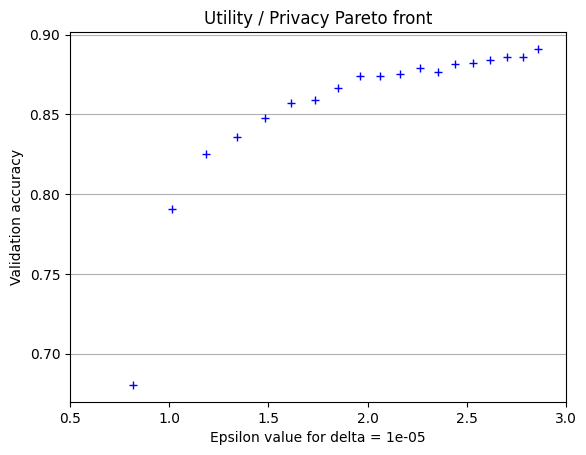

In [80]:
import matplotlib.pyplot as plt
import numpy as np 

plt.figure()

plt.plot(hist.history['epsilon'], hist.history['val_accuracy'], 'b+')

plt.xlabel(f'Epsilon value for delta = {delta}')
plt.ylabel('Validation accuracy')

plt.xticks(np.linspace(0,1,10))
plt.xticks(np.linspace(0.5,3.0,6))

plt.xlim(left=0.5); plt.grid(axis = 'y')

plt.title("Utility / Privacy Pareto front")